Plot ACFs

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle
import numpy as np
import pandas as pd

from isttc.scripts.cfg_global import project_folder_path
from isttc.tau import func_single_exp_monkey

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

save_fig = False

### Load data (spike trains and calculated acf's)

In [32]:
with open(results_folder + 'tau_pearsonr_trial_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'tau_acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')
print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')

summary_tau_df = pd.read_pickle(results_folder + 'summary_tau_all_long_df.pkl')
print(f'len summary_tau_df {len(summary_tau_df)}, per method {len(summary_tau_df)/4}')

len pearsonr_trial_avg_dict 100000
len sttc_trial_concat_dict 100000
len isttc_full_dict 100000
len acf_full_dict 100000
len summary_tau_df 326180, per method 81545.0


In [56]:
summary_tau_df['ci_zero_excluded'] = (
    (summary_tau_df['tau_lower'] > 0) | (summary_tau_df['tau_upper'] < 0)
).astype(int)

summary_tau_df_subset = summary_tau_df[['unit_id', 'fit_r_squared',
       'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true',
       'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'lv', 'ci_zero_excluded']].copy()
len(summary_tau_df_subset)

326180

In [57]:
summary_tau_df_subset.query('fit_r_squared > 0.8')

,unit_id,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,lv,ci_zero_excluded
0,0,0.998369,True,acf_full,110.894975,7.741821,0.851099,150.923515,40.028540,26.522401,0.197350,1.307775,1
1,1,0.997899,True,acf_full,128.410512,4.394396,0.858098,147.947233,19.536721,13.205195,0.262120,1.345006,1
2,2,0.984960,True,acf_full,261.372568,8.587393,0.528805,267.002290,5.629722,2.108492,1.786061,1.068416,1
3,3,0.889719,True,acf_full,197.510466,6.976707,0.300692,194.403797,3.106670,1.598050,3.400250,1.055631,1
4,4,0.995737,True,acf_full,185.898174,0.950832,0.691458,239.986489,54.088315,22.538067,0.583014,1.357205,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326171,99989,0.881376,True,sttc_trial_concat,59.239718,8.494425,0.789903,98.245872,39.006154,39.702589,1.042001,1.372508,1
326172,99990,0.885597,True,sttc_trial_concat,975.323950,1.329388,0.544444,220.144995,755.178955,343.037076,60.494020,1.477357,0
326174,99992,0.870478,False,sttc_trial_concat,555.756639,8.633957,0.672935,267.873056,287.883583,107.470153,22.047592,1.135003,1
326176,99994,0.902220,True,sttc_trial_concat,409.519723,6.938018,0.608313,239.402724,170.116998,71.058923,10.766081,1.136797,1


In [79]:
df = summary_tau_df_subset.copy()

# Pivot fit_r_squared
pivot_r2 = df.pivot(index='unit_id', columns='method', values='fit_r_squared')

# Pivot acf_decline
pivot_decline = df.pivot(index='unit_id', columns='method', values='acf_decline')

# Pivot ci_zero_excluded
pivot_ci = df.pivot(index='unit_id', columns='method', values='ci_zero_excluded')


# Conditions:
mask_units = (
    # 1. r² conditions
    (pivot_r2['acf_full'] > 0.5) &
    (pivot_r2['isttc_full'] > 0.5) &
    (pivot_r2['pearsonr_trial_avg'] < 0.5) &
    (pivot_r2['sttc_trial_concat'] < 0.5) 

    # # 2. extra conditions for low-performing methods
    # (pivot_decline['pearsonr_trial_avg'] == False) &
    # (pivot_decline['sttc_trial_concat'] == False) &
    # (pivot_ci['pearsonr_trial_avg'] == 1) &
    # (pivot_ci['sttc_trial_concat'] == 1)
)

selected_units = pivot_r2[mask_units].index

df_final = (
    df[df['unit_id'].isin(selected_units)]
    .sort_values(['unit_id', 'method'])
    .reset_index(drop=True)
)

df_final

,unit_id,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,lv,ci_zero_excluded
0,3,0.889719,True,acf_full,197.510466,6.976707,0.300692,194.403797,3.106670,1.598050,3.400250,1.055631,1
1,3,0.862334,True,isttc_full,223.045437,6.976707,0.300692,194.403797,28.641641,14.733066,4.568356,1.055631,1
2,3,0.412457,True,pearsonr_trial_avg,548.658840,6.976707,0.300692,194.403797,354.255043,182.226402,66.598265,1.055631,0
3,3,0.494420,True,sttc_trial_concat,420.580503,6.976707,0.300692,194.403797,226.176706,116.343770,34.680259,1.055631,0
4,4,0.995737,True,acf_full,185.898174,0.950832,0.691458,239.986489,54.088315,22.538067,0.583014,1.357205,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125199,99995,0.166813,True,sttc_trial_concat,33.636771,2.672839,0.244627,125.243251,91.606480,73.142848,4.494896,1.178739,0
125200,99997,0.906062,True,acf_full,149.742178,5.604441,0.258915,174.189672,24.447494,14.034985,2.192079,1.064661,1
125201,99997,0.929101,True,isttc_full,145.325980,5.604441,0.258915,174.189672,28.863692,16.570266,1.815717,1.064661,1
125202,99997,0.236931,False,pearsonr_trial_avg,112.612767,5.604441,0.258915,174.189672,61.576906,35.350492,9.274544,1.064661,0


### Plot

In [11]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

#colors = [color_acf_full, color_isttc_full]

In [83]:
df_final['unit_id'].values[:20]

array([ 3,  3,  3,  3,  4,  4,  4,  4,  8,  8,  8,  8, 12, 12, 12, 12, 13,
       13, 13, 13])

In [86]:
isttc_full_dict[unit_to_plot]['acf']

[np.float64(1.0),
 np.float64(0.15101769306319757),
 np.float64(0.11768183068975072),
 np.float64(0.07845967466697792),
 np.float64(0.07248835137722388),
 np.float64(0.06494394795470393),
 np.float64(0.048142762644209115),
 np.float64(0.03684037578234413),
 np.float64(0.02566576200855572),
 np.float64(0.02379296962826264),
 np.float64(0.023492962844285308),
 np.float64(0.025532848162801467),
 np.float64(0.01477641879618435),
 np.float64(0.023530416994376007),
 np.float64(0.019540349811841853),
 np.float64(0.019812257425630066),
 np.float64(0.017799673784076066),
 np.float64(0.002705495796360027),
 np.float64(0.00957367795811437),
 np.float64(-0.004183073140770527),
 np.float64(0.006522308364685267)]

#### ACFs where iSTTC is better

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


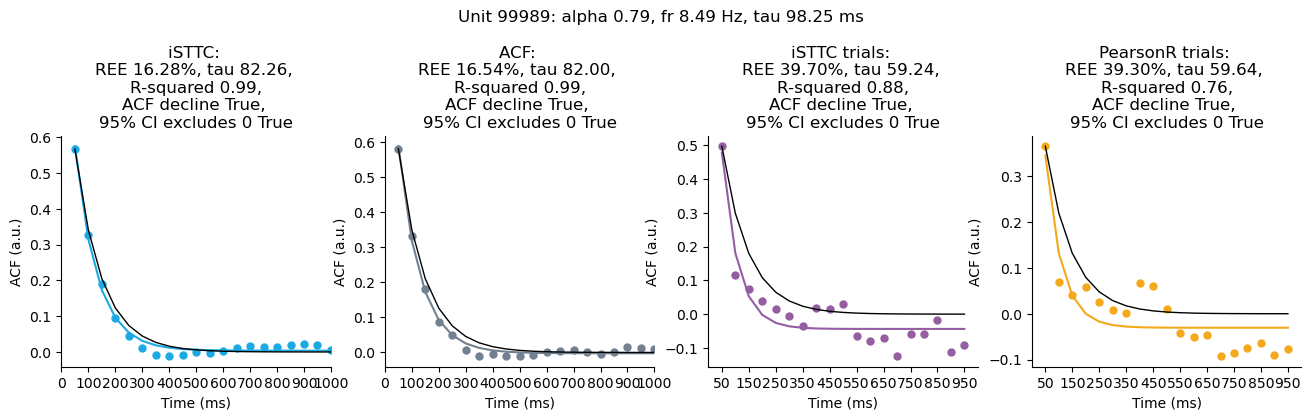

In [89]:
unit_to_plot = 99989

fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)

n_lags = 20
t = np.linspace(0, n_lags, n_lags+1).astype(int)

axes[0].plot(t[1:], isttc_full_dict[unit_to_plot]['acf'][1:], lw=0, color=color_isttc_full, alpha=1, marker='o', markersize='5')
axes[0].plot(t[1:], func_single_exp_monkey(t[1:], *isttc_full_dict[unit_to_plot]['taus']['popt']), color=color_isttc_full)

axes[1].plot(t[1:], acf_full_dict[unit_to_plot]['acf'][1:], lw=0, color=color_acf_full, alpha=1, marker='o', markersize='5')
axes[1].plot(t[1:], func_single_exp_monkey(t[1:], *acf_full_dict[unit_to_plot]['taus']['popt']), color=color_acf_full)

t_trials = np.linspace(0, n_lags-1, n_lags).astype(int)
print(t_trials)

axes[2].plot(t_trials[1:], sttc_trial_concat_dict[unit_to_plot]['acf'][0][1:], lw=0, color=color_sttc_trail_concat, alpha=1, marker='o', markersize='5')
axes[2].plot(t_trials[1:], func_single_exp_monkey(t_trials[1:], *sttc_trial_concat_dict[unit_to_plot]['taus'][0]['popt']), color=color_sttc_trail_concat)

axes[3].plot(t_trials[1:], pearsonr_trial_avg_dict[unit_to_plot]['acf'][0][1:], lw=0, color=color_pearson_trail_avg, alpha=1, marker='o', markersize='5')
axes[3].plot(t_trials[1:], func_single_exp_monkey(t_trials[1:], *pearsonr_trial_avg_dict[unit_to_plot]['taus'][0]['popt']), color=color_pearson_trail_avg)

# get analytical tau
alpha = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['alpha'].values[0] 
tau_ms = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['tau_ms_true'].values[0]   
fr = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['fr'].values[0]   

lags = np.linspace(0, 1000, 21)
acf_shape = np.exp(-lags / tau_ms)

# iSTTC scaling
isttc_emp = isttc_full_dict[unit_to_plot]['acf']
isttc_scale = isttc_emp[1] / acf_shape[1]
isttc_acf_analytical_scaled = isttc_scale * acf_shape

# ACF scaling
acf_emp = acf_full_dict[unit_to_plot]['acf']
acf_scale = acf_emp[1] / acf_shape[1]
acf_acf_analytical_scaled = acf_scale * acf_shape

# iSTTC trials scaling
isttc_trials_emp = sttc_trial_concat_dict[unit_to_plot]['acf'][0]
isttc_trials_scale = isttc_trials_emp[1] / acf_shape[1]
isttc_trials_acf_analytical_scaled = isttc_trials_scale * acf_shape[:-1]

# PearsonR scaling
pearsonr_trials_emp = pearsonr_trial_avg_dict[unit_to_plot]['acf'][0]
pearsonr_trials_scale = pearsonr_trials_emp[1] / acf_shape[1]
pearsonr_trials_acf_analytical_scaled = pearsonr_trials_scale * acf_shape[:-1]

axes[0].plot(t[1:], isttc_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)
axes[1].plot(t[1:], acf_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)
axes[2].plot(t_trials[1:], isttc_trials_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)
axes[3].plot(t_trials[1:], pearsonr_trials_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)

fig.suptitle(f'Unit {unit_to_plot}: alpha {alpha:.2f}, fr {fr:.2f} Hz, tau {tau_ms:.2f} ms', y=1.3)

isttc_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['tau_diff_rel'].values[0]
isttc_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['fit_r_squared'].values[0]
isttc_decline = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['acf_decline'].values[0]
isttc_ci = True if summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['ci_zero_excluded'].values[0] else False
isttc_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['tau_ms'].values[0]
axes[0].set_title(f'iSTTC: \nREE {isttc_ree:.2f}%, tau {isttc_tau:.2f}, \nR-squared {isttc_r2:.2f},\nACF decline {isttc_decline}, \n95% CI excludes 0 {isttc_ci}')

acf_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['tau_diff_rel'].values[0]
acf_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['fit_r_squared'].values[0]
acf_acf_decline = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['acf_decline'].values[0]
acf_ci = True if summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['ci_zero_excluded'].values[0] else False
acf_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['tau_ms'].values[0]
axes[1].set_title(f'ACF: \nREE {acf_ree:.2f}%, tau {acf_tau:.2f}, \nR-squared {acf_r2:.2f},\nACF decline {acf_acf_decline}, \n95% CI excludes 0 {acf_ci}')

isttc_trials_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "sttc_trial_concat"')['tau_diff_rel'].values[0]
isttc_trials_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "sttc_trial_concat"')['fit_r_squared'].values[0]
isttc_trials_acf_decline = summary_tau_df.query('unit_id == @unit_to_plot and method == "sttc_trial_concat"')['acf_decline'].values[0]
isttc_trials_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "sttc_trial_concat"')['fit_r_squared'].values[0]
isttc_trials_ci = True if summary_tau_df.query('unit_id == @unit_to_plot and method == "sttc_trial_concat"')['ci_zero_excluded'].values[0] else False
isttc_trials_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "sttc_trial_concat"')['tau_ms'].values[0]
axes[2].set_title(f'iSTTC trials: \nREE {isttc_trials_ree:.2f}%, tau {isttc_trials_tau:.2f}, \nR-squared {isttc_trials_r2:.2f},\nACF decline {isttc_trials_acf_decline}, \n95% CI excludes 0 {isttc_trials_ci}')

pearsonr_trials_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "pearsonr_trial_avg"')['tau_diff_rel'].values[0]
pearsonr_trials_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "pearsonr_trial_avg"')['fit_r_squared'].values[0]
pearsonr_trials_acf_decline = summary_tau_df.query('unit_id == @unit_to_plot and method == "pearsonr_trial_avg"')['acf_decline'].values[0]
pearsonr_trials_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "pearsonr_trial_avg"')['fit_r_squared'].values[0]
pearsonr_trials_ci = True if summary_tau_df.query('unit_id == @unit_to_plot and method == "pearsonr_trial_avg"')['ci_zero_excluded'].values[0] else False
pearsonr_trials_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "pearsonr_trial_avg"')['tau_ms'].values[0]
axes[3].set_title(f'PearsonR trials: \nREE {pearsonr_trials_ree:.2f}%, tau {pearsonr_trials_tau:.2f}, \nR-squared {pearsonr_trials_r2:.2f},\nACF decline {pearsonr_trials_acf_decline}, \n95% CI excludes 0 {pearsonr_trials_ci}')

axes[0].set_xticks(np.linspace(0, 20, 11).astype(int))
axes[0].set_xticklabels(np.linspace(0, 1000, 11).astype(int))

axes[1].set_xticks(np.linspace(0, 20, 11).astype(int))
axes[1].set_xticklabels(np.linspace(0, 1000, 11).astype(int))

axes[2].set_xticks(np.linspace(1, 19, 10).astype(int))
axes[2].set_xticklabels(np.linspace(50, 950, 10).astype(int))

axes[3].set_xticks(np.linspace(1, 19, 10).astype(int))
axes[3].set_xticklabels(np.linspace(50, 950, 10).astype(int))

for ax in axes.flat:
    ax.set_ylabel('ACF (a.u.)')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim([0,20])

sns.despine()

fig.savefig(results_folder + 'acf_plots\\exclusion\\' + f"acf_plot_unit_{unit_to_plot}.png", dpi=300, bbox_inches='tight')
fig.savefig(results_folder + 'acf_plots\\exclusion\\' + f"acf_plot_unit_{unit_to_plot}.svg", dpi=300, bbox_inches='tight')